# Problem 

Optimal time planning of a collection of projects provided in a portfolio.  

Variables and conditions:  
- two project classes: Oil and Gas  
- varying earlist porject execution year  
- varying project execution time  
- varying project production profile  
- negligible costs for all projects

The production profile is given in terms of yearly production, expressed in units of $\left[\frac{\text{m}^3}{\text{day}}\right]$ for Oil 
and $\left[\frac{\text{km}^3}{\text{day}}\right]$ for Gas, for 2021 to 2040.  

###### Scenarios
Two distinct scenarios to consider:  
1. optimise project sequence to maximise Oil production in the period 2021-2025  
2. optimise project sequence to maximise Oil production in the period 2021-2025,  
maintaining gas production as long as possible around 1M m$^3$/day from 2021 onwards

In [1]:
import numpy as np
import pandas as pd
from ProjectPlanning import *

import warnings
warnings.filterwarnings('ignore')

For convenient data handling, let's import the portfolio data into a pandas DataFrame

In [2]:
portfolio_filename = 'WSE_BusinessPlanning_InputToChallenge.xlsx'
dfportfolio = pd.read_excel(portfolio_filename)

The portfolio contains both **Oil** and **Gas** projects  

In [3]:
gas_columns = [col for col in dfportfolio.drop('Oil/Gas', axis=1).columns.values if 'Gas' in col]
oil_columns = [col for col in dfportfolio.drop('Oil/Gas', axis=1).columns.values if 'Oil' in col]

We can safely split the portfolio into separate _Oil_ and _Gas_ DataFrames

### Oil

First consider the Oil projects only

In [4]:
dfoil = dfportfolio[dfportfolio['Oil/Gas']=='Oil']
dfoil = dfoil.drop(['Oil/Gas',*gas_columns], axis=1).fillna(0,axis=1).reset_index(drop=True)

Collect all Oil projects names

In [5]:
oil_projects_names = dfoil[dfoil.columns[0]].values

Transpose the DataFrame to more conveniently access each project using column labels

In [6]:
%%capture
dfoil = dfoil.T
dfoil.columns = oil_projects_names
dfoil.drop('Project Name', inplace=True)
dfoil.reset_index()

Check the behaviour of production profile for a few projects

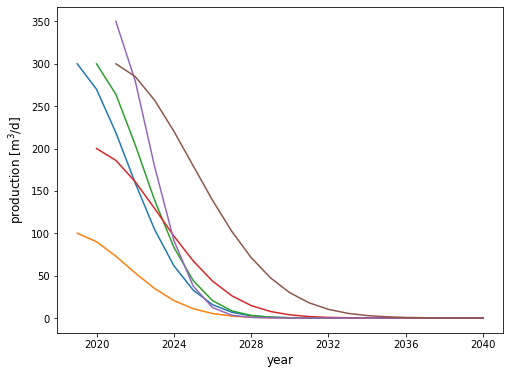

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(8,6))
for p in oil_projects_names[::10]:
    project = dfoil[p].to_numpy(dtype=float)[2:]
    first_non_zero = np.where(project!=0)[0][0]
    project = project[first_non_zero:]
    
    indxs = [ln for ln in dfoil.index.values[2:]]
    years = [datetime(int(idx.split(' ')[-1]),1,1).date() for idx in indxs]
    years = years[first_non_zero:]

    ax.plot(years, project, '-');
    ax.set_xlabel('year', fontsize=12);
    ax.set_ylabel(r'production [m$^{3}$/d]', fontsize=12);

The production profiles for the Oil extraction projects are expressed in units of $\left[\frac{\text{m}^3}{\text{day}}\right]$ for a given year.  
Supposing this to be the yearly avarage of the daily production, we can get the production profiles on a daily basis by interpolating the curves.  

In [8]:
oil_projects = dataframe_to_dictionary(dfoil)

Given that we need to maximise the production in the five-yeras period 2021-2025,  
we are interested only in the first 5 years of production profile of each project. 

For each oil project, determine the actual production profile over the first five years of operations.  
Below an example for the first Oil project available

Project name: Development_20_Oil , first spud year: 2019 , drill duration: 90


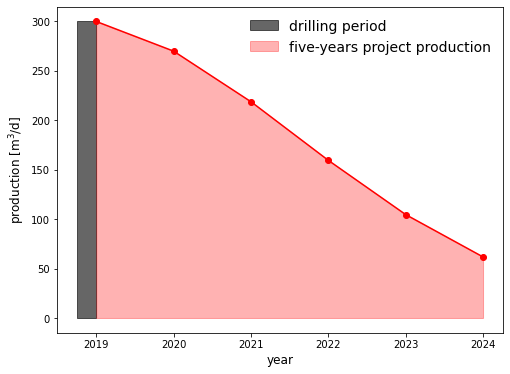

In [9]:
p = 0
project = oil_projects_names[p]
spud = oil_projects[project]['spud']
drill = oil_projects[project]['drill']
years = oil_projects[project]['years']
prod_profile = oil_projects[project]['profile']
prof_curve = oil_projects[project]['curve']

print('Project name: %s , first spud year: %i , drill duration: %i'%(project, spud, drill))

Dyears = mdates.num2date(years)
fig, ax = plt.subplots(1,1,figsize=(8,6))
drilldays = mdates.num2date(range(int(years[0]-drill),int(years[0])))
ax.fill_between(drilldays, 0, prod_profile[0], color='k', alpha=0.6, label='drilling period');
ax.plot(Dyears[:6], prod_profile[:6], 'r-');
ax.plot(Dyears[:6], prof_curve(years[:6]), 'ro', zorder=4);
ax.fill_between(Dyears[:6], 0, prof_curve(years[:6]), alpha=0.3, color='r', label='five-years project production')
ax.set_xlabel('year', fontsize=12);
ax.set_ylabel(r'production [m$^{3}$/d]', fontsize=12);
ax.legend(fontsize=14, framealpha=0);

Determine the cumulative portfolio production achievable from all Oil projects over the period of interest.  
We get this by integrating the interpolation objects over the first five years of data and summing the results.

In [10]:
from scipy.integrate import quad

O = 0 
for p,project in oil_projects.items():
    years = project['years']
    prof_curve = project['curve']
    iyear = years[0]
    fyear = years[5]
    proj_tot_prod = quad(prof_curve, iyear, fyear)[0]
    O += proj_tot_prod

print('Total cumulative production from all Oil projects: {:,} [m3]'.format(O))

Total cumulative production from all Oil projects: 14,182,127.019728838 [m3]


This quantity represents the target production for the period 2021-2025.

In [11]:
total_days = 365*4 + 366
# days in five years from Jan 1st 2021 to January 1st 2026 (2024 is a leap year)

day0 = mdates.datestr2num('2021-1-1')

Note: the current implementation attributes the dates given in the DataFrame to the first day of the corresponding year.  
This is an arbitrary choice which does not impact the results, given that some other start date within the same year  
would lead to the same results (eg. shifting by 180 day to have it representing the middle of the year).

#### Scenario 1 : optimize the project sequence for maximum Oil production in 2021-2025

To maximise the Oil production over the period 2021-2025, we could adopt the following  
scheme to order the execution time of Oil projects:  

- split the portfolio projects based on their earlier spud year  
- consider those projects with spud year earlier than period start  
- order the resulting projects in decreasing total production  
- order the resulting projects in decreasing drill duration  
- starting from longest drilling project(s), populate the  
projects sequence including the new projects and subtracting 
the drilling time from the period start date  
- consider projects with spud year later or equal than period start  
- order the resulting projects in decreasing total production  
- order the resulting projects in decreasing drill duration  
- starting from longest drilling project(s), populate the   
projects sequence inclduing the new projects and adding 
the drilling time to the period start date  
- combine to the sequences  

Implementing the scheme above leads to the following result

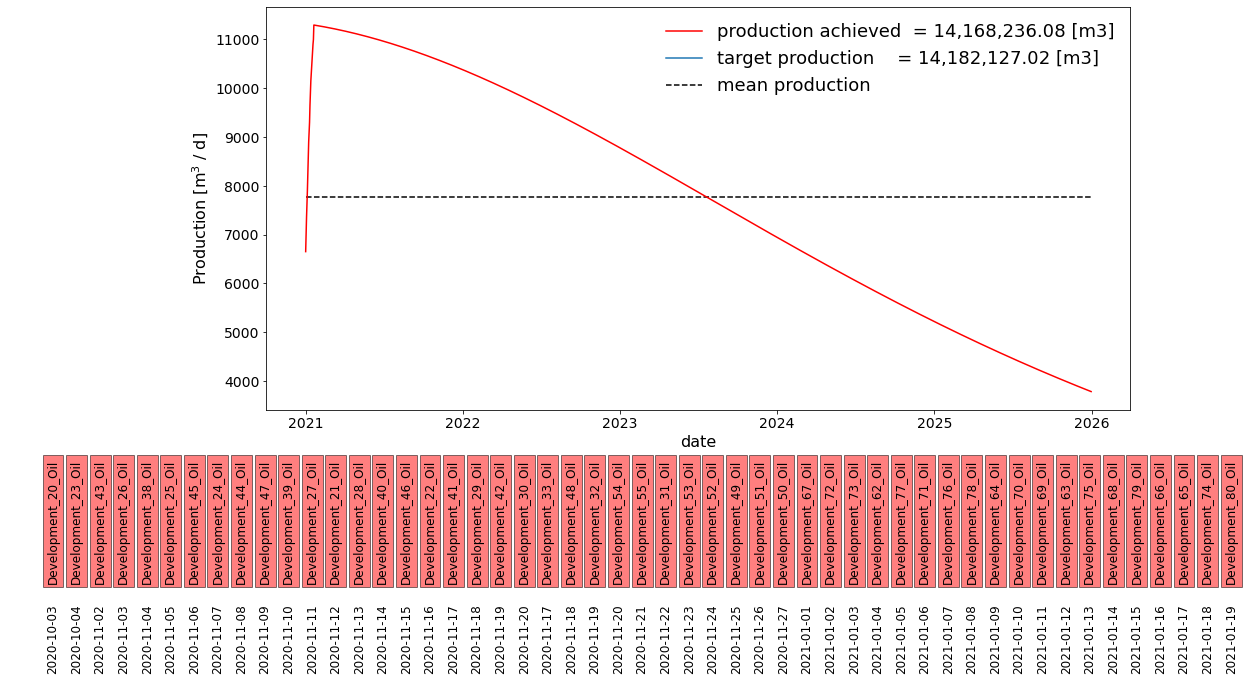

In [12]:
PP = Projects_Planner(day0, total_days, oil_projects, max_year=5)

total_day_prod = PP()
total_day_arr = np.arange(total_days)
period = mdates.num2date(day0+total_day_arr)

#print(len(PP.used_projects))
total_prod = sum(total_day_prod[1:]+total_day_prod[:-1])/2

fig = plt.figure(figsize=(12,8))
frame1 = fig.add_axes((.3,.3,1,.7))

plt.plot(period, total_day_prod, 'r', label='{:20} = {:,.2f} [m3]'.format('production achieved', total_prod));
plt.plot([], [], label='{:20} = {:,.2f} [m3]'.format('target production', PP.total_prod));
plt.hlines(PP.global_mean, period[0], period[-1], linestyles='dashed', label='mean production');
plt.legend(fontsize=18, framealpha=0);
#plt.xlim(datetime(2020,9,1), datetime(2026,1,10));
plt.xlabel('date', fontsize=16);
plt.ylabel(r'Production [m$^3$ / d]', fontsize=16);
plt.tick_params(labelsize=14);

frame2 = fig.add_axes((0,0,1,.2))
for n,(start,ind) in enumerate(PP.projects_sequence):
    date = mdates.num2date(day0+start).date()
    project_name = PP.projects_names[ind]
    plt.plot(2*n, 0);
    plt.text(3*n, 0, project_name, fontdict={'rotation':90, 'fontsize':12}, bbox=dict(facecolor='red', alpha=0.5));
    plt.text(3*n, -40, date, fontdict={'rotation':90, 'fontsize':12});
plt.ylim(-1, 50);
plt.axis('off');

frame2.set_xticklabels([]);
frame2.set_yticklabels([]);

### Gas

Next consider the Gas projects

In [13]:
dfgas = dfportfolio[dfportfolio['Oil/Gas']=='Gas']
dfgas = dfgas.drop(['Oil/Gas', *oil_columns], axis=1).fillna(0, axis=1).reset_index(drop=True)

Get the Gas projects names

In [14]:
gas_projects_names = dfgas[dfgas.columns[0]].values

Transpose the gas projects dataframe for later convenience

In [15]:
%%capture
dfgas = dfgas.T
dfgas.columns = gas_projects_names
dfgas.drop('Project Name', inplace=True)
dfgas.reset_index()

As before, we examine the production profile of several Gas projects

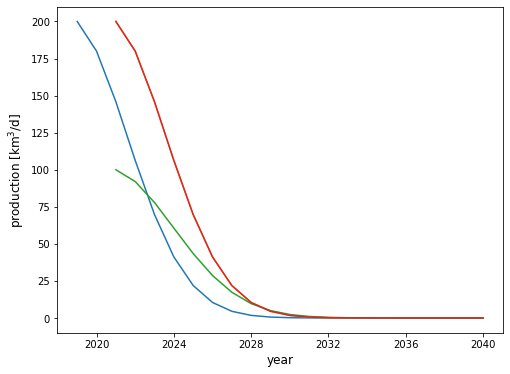

In [16]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

for p in gas_projects_names[::10]:
    project = dfgas[p].to_numpy(dtype=float)[2:]
    first_non_zero = np.where(project!=0)[0][0]
    project = project[first_non_zero:]
    
    indxs = [ln for ln in dfgas.index.values[2:]]
    years = [datetime(int(idx.split(' ')[-1]),1,1).date() for idx in indxs]
    years = years[first_non_zero:]

    ax.plot(years, project, '-');
    ax.set_xlabel('year', fontsize=12);
    ax.set_ylabel(r'production [km$^{3}$/d]', fontsize=12);

Since the production profile for Gas projects is given in units of $\frac{\text{km}^3}{\text{d}}$, 
we need to rescale them using $ \text{km}^3 = 10^9 \text{m}^3 $

In [17]:
gas_projects = dataframe_to_dictionary(dfgas, scale=1e9)

Check the behaviour of the first projects in the list

Project name: Development_34_Gas , first spud year: 2019 , drill duration: 45


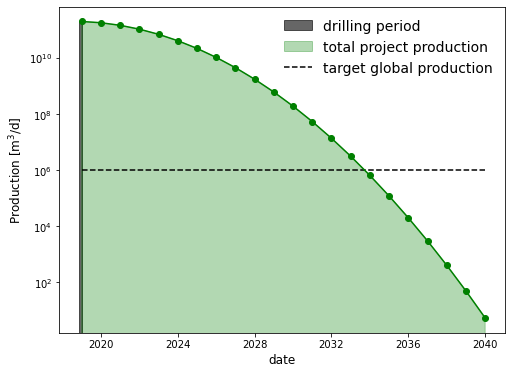

In [18]:
p = 0
project = gas_projects_names[p]
spud = gas_projects[project]['spud']
drill = gas_projects[project]['drill']
years = gas_projects[project]['years']
prod_profile = gas_projects[project]['profile']
prof_curve = gas_projects[project]['curve']

print('Project name: %s , first spud year: %i , drill duration: %i'%(project, spud, drill))

Dyears = mdates.num2date(years)
fig = plt.figure(figsize=(8,6))
drilldays = mdates.num2date(range(int(years[0]-drill),int(years[0])))
plt.fill_between(drilldays, 0, prod_profile[0], color='k', alpha=0.6, label='drilling period');
plt.semilogy(Dyears, prod_profile, 'g-');
plt.semilogy(Dyears, prof_curve(years), 'go', zorder=4);
plt.fill_between(Dyears, 0, prof_curve(years), alpha=0.3, color='g', label='total project production')
plt.hlines(1e6, Dyears[0], Dyears[-1], linestyles='dashed', label='target global production');
plt.xlabel('date', fontsize=12);
plt.ylabel(r'Production [m$^{3}$/d]', fontsize=12);
plt.legend(fontsize=14, framealpha=0);

#### Scenario 2 : Scenario 1 with a desire that gas remains as long as possible around 1M m3/d from 2021 onwards.

Given that all Gas projects have production profiles yielding volumes several orders of magnitude higher than the target,  
several conclusions can be already drawn: in order to meet the requirement of this scenario 
- no project with earlier spud year starting on 2021 should be considered, otherwise it's contribution would sky-rocket the global production  
- a combination of projects with earlier spud years should be considered  
- such combination should produce a cumulative contribution $\sim 10^6 \frac{\text{m}^3}{\text{d}}$ by the start of 2021  
- such combination should produce the longest possible production tail at the target value 
- a range of acceptance around this target production could be defined  

Let's restrict the available Gas projects to those having spud year earlier than the start of the reference period (2021)

In [19]:
PP = Projects_Planner(day0, total_days, gas_projects)

gas_projects_length = len(gas_projects)
first_year = mdates.num2date(day0).date().year

indxs = np.arange(gas_projects_length)
spuds = np.array([pr['spud'] for pr in gas_projects.values()])
drill = np.array([pr['drill'] for pr in gas_projects.values()])
effective = np.array([pr['effective'] for pr in gas_projects.values()])

before = np.where(spuds<first_year)[0]
indxs_before = indxs[before]
drill_before = drill[before]
effective_before = effective[before]

Now investigate at which point (index) the available projects decrease below the target productivity

In [20]:
lower = []
lower_ind = []

for e,eff in enumerate(effective_before):
    ind = np.where(eff<1e6)[0]
    if len(ind)>0:
        lower.append(e)
        lower_ind.append(ind[0])
    print(gas_projects_names[indxs_before[e]], ind[0] if len(ind)>0 else ind)

Development_34_Gas 5379
Development_35_Gas 5995
Development_36_Gas 5379
Development_37_Gas []
Development_56_Gas 7095
Development_57_Gas 5312
Development_58_Gas 4870
Development_59_Gas 5312
Development_60_Gas 4296
Development_61_Gas []


Two projects never produce less than the target productivity and can be thus excluded

In [21]:
indxs_lower = indxs_before[lower]
drill_lower = drill_before[lower]
effective_lower = effective[lower]

len(indxs_lower)

8

Given the small number of truly available projects, we can calculate all possible combinations  

Since the various projects will have tail below $10^6$ of different lengths, we need an expedient to sum them consistently.  
A possibility is to build an empty array and filling from the start with the tails from every project in the combination

In [22]:
from itertools import combinations

initial_indx = range(len(indxs_lower))

tail_ind = []
tail_sum = []
tail_comb = []

i = 0
tail_size = 5000
for r in initial_indx[1:]:
    for comb in combinations(initial_indx,r):
        tail_comb.append(comb)
        tail_temp = np.zeros(tail_size)
        tail_ind.append(i)
        i += 1
        
        for c in comb:
            len_eff = len(effective_lower[c][lower_ind[c]:])
            missing = tail_size - len_eff
            tail_eff = np.zeros_like(tail_temp)
            tail_eff[:len_eff] = effective_lower[c][lower_ind[c]:]
            tail_temp += tail_eff
        
        tail_sum.append(tail_temp)

tail_sum = np.array(tail_sum)

Now we need to define a measure to estimate the most favourable combination,  
eg. the one which leads to the longest tail at the desired height $\sim 10^6 \frac{\text{m}^3}{\text{d}}$  

Let's examine the first 1000 days of the possible combinations of projects whose tail production is summed,  
focusing on the interval following the moment the total production is around $10^6$.

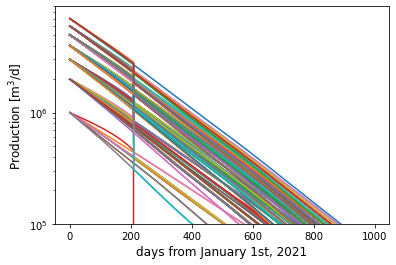

In [23]:
for t in range(len(tail_sum)):
    plt.semilogy(range(tail_size)[:1000], tail_sum[t,:1000]);
plt.ylim(1e5, 9e6);
plt.xlabel('days from January 1st, 2021', fontsize=12);
plt.ylabel(r'Production [m$^{3}$/d]', fontsize=12);

This suggests some cut on the possible combinations based on the height of the curves on the first day  
(in this case, the start of 2021)

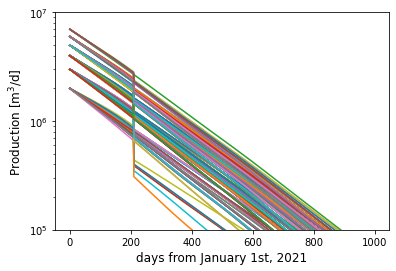

In [24]:
reduce_tail_ind = np.where(np.logical_and(1e6<tail_sum[:,0], tail_sum[:,0]<1e7))[0]

for t in reduce_tail_ind:
    plt.semilogy(range(tail_size)[:1000], tail_sum[t,:1000]);
plt.ylim(1e5, 1e7);
plt.xlabel('days from January 1st, 2021', fontsize=12);
plt.ylabel(r'Production [m$^{3}$/d]', fontsize=12);

Next we consider the combinations which lead to the lowest decrease over 1000 days

In [25]:
latest = 1000
drop_tail = []
for ii in reduce_tail_ind:
    drop = tail_sum[ii][0] - tail_sum[ii,latest]
    if drop > 0:
        drop_tail.append(drop)
    else:
        drop_tail.append(0)

drop_tail_ind = np.where(drop_tail==min(drop_tail))[0]

comb_ind1 = reduce_tail_ind[drop_tail_ind[0]]
comb_ind2 = reduce_tail_ind[drop_tail_ind[1]]

Get the corresponding projects combinations

In [26]:
tail_comb[comb_ind1], tail_comb[comb_ind2]

((1, 4), (1, 6))

With these choices, we get the projects whose tails sum to a production having the slowest drop after 1000 days  
from the start of the reference period. These projects are

In [27]:
projects1 = [[indxs_lower[i],lower_ind[i]] for i in tail_comb[comb_ind1]]
projects2 = [[indxs_lower[i],lower_ind[i]] for i in tail_comb[comb_ind2]]

print('%16s %10s %10s %10s'%('project','spud', 'drill', 'delay'))

for i in range(2):
    exec('project = projects{}'.format(i+1))
    for (pr,dy) in projects1:
        name = gas_projects_names[pr]
        project = gas_projects[name]
        print('%16s %8i %8i %12i'%(name, project['spud'], project['drill'], dy))
    print()

         project       spud      drill      delay
Development_35_Gas     2019       30         5995
Development_57_Gas     2020       45         5312

Development_35_Gas     2019       30         5995
Development_57_Gas     2020       45         5312



As an illustration, I consider only the first possible sequence

In [28]:
projects_sequence_tail = []

for pr,delay in projects1:
    name = gas_projects_names[pr]
    project = gas_projects[name]
    drill = project['drill']
    projects_sequence_tail.append((-delay, pr))

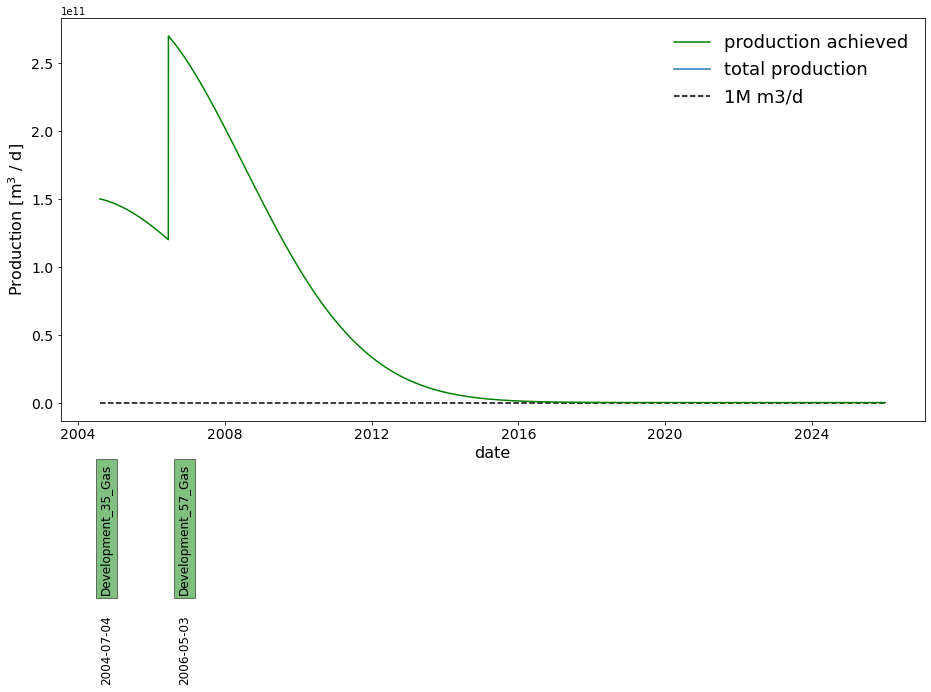

In [29]:
old_days = min(projects_sequence_tail)[0]
past_days = day0 + old_days
longer_days = abs(old_days) + total_days

total_day_prod = []
total_day_arr = np.arange(longer_days)
period = mdates.num2date(past_days+total_day_arr)

PP = Projects_Planner(past_days, longer_days, gas_projects)
PP.clear_projects()

n = 0
start,ind = projects_sequence_tail[n]
PP.add_projects(gas_projects_names[ind], n)
n += 1

for day in range(longer_days):
    if n<len(projects_sequence_tail):
        start,ind = projects_sequence_tail[n]
        if day == start-old_days:
            PP.add_projects(gas_projects_names[ind], day)
            n += 1
    
    P = PP.project_production(day)
    total_day_prod.append(P)

#print(len(PP.used_projects))
total_prod = sum(total_day_prod[1:]+total_day_prod[:-1])/2

fig = plt.figure(figsize=(12,8))
frame1 = fig.add_axes((0,.3,1,.7))

plt.plot(period, total_day_prod, 'g', label='production achieved');
plt.plot([], [], label='total production');
plt.hlines(1e6, period[0], period[-1], linestyles='dashed', label='1M m3/d');
plt.legend(fontsize=18, framealpha=0);
#plt.xlim(datetime(2021,1,1), datetime(2026,1,1));
#plt.ylim(1e5, 1e7);
plt.xlabel('date', fontsize=16);
plt.ylabel(r'Production [m$^3$ / d]', fontsize=16);
plt.tick_params(labelsize=14);

frame2 = fig.add_axes((0,0,1,.2))
for n,(date,name) in enumerate(PP.projects_time_sequence):
    plt.plot(n, 0);
    plt.text(n/10, 0, name, fontdict={'rotation':90, 'fontsize':12}, bbox=dict(facecolor='green', alpha=0.5));
    plt.text(n/10, -40, date, fontdict={'rotation':90, 'fontsize':12});
plt.ylim(-1, 50);
plt.axis('off');

frame2.set_xticklabels([]);
frame2.set_yticklabels([]);

Plotting in log format and zooming on the range of interest we can observe the trend of the combination of profiles

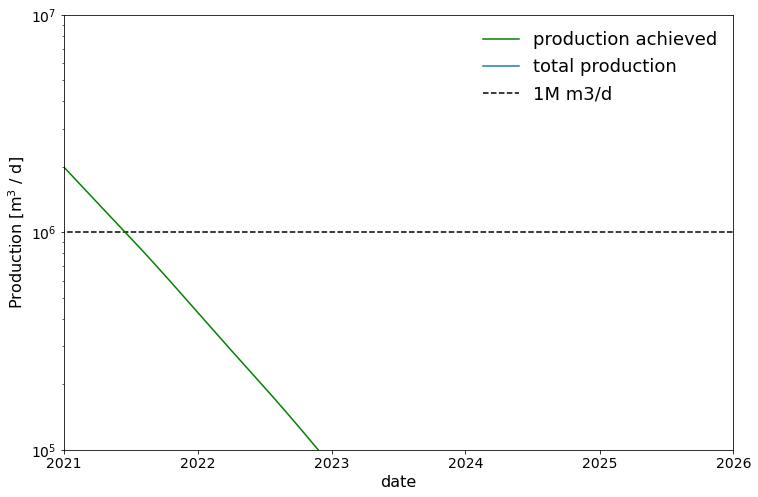

In [30]:
fig = plt.figure(figsize=(12,8))

plt.semilogy(period, total_day_prod, 'g', label='production achieved');
plt.plot([], [], label='total production');
plt.hlines(1e6, period[0], period[-1], linestyles='dashed', label='1M m3/d');
plt.legend(fontsize=18, framealpha=0);
plt.xlim(datetime(2021,1,1), datetime(2026,1,1));
plt.ylim(1e5, 1e7);
plt.xlabel('date', fontsize=16);
plt.ylabel(r'Production [m$^3$ / d]', fontsize=16);
plt.tick_params(labelsize=14);